# Stochastic Gradient Descent from Scratch

This notebook expands the upon the [*Gradient Descent from Scratch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/gradient-descent-from-scratch.ipynb) to introduce *stochastic* gradient descent (SGD).

### Simulate data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)
np.random.seed(42)

Create a vector tensor `x` with eight million points spaced evenly from zero to eight: 

In [3]:
n = 8000000

In [4]:
x = torch.linspace(0., 8., n) # using typical 'x' convention for vector instead of 'xs'

Use the same line equation as in the [*Regression in PyTorch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb) to simulate eight million $y$ values for the vector `y`. That is, $m = -0.5$ and $b = 2$:
$$y = mx + b + \epsilon = -0.5x + 2 + \mathcal{N}(0, 1)$$

In [5]:
y = -0.5*x + 2 + torch.normal(mean=torch.zeros(n), std=1) # 'y' vector instead of 'ys'

Let's randomly sample a couple thousand points for the purpose of data visualization: 

In [6]:
indices = np.random.choice(n, size=2000, replace=False)

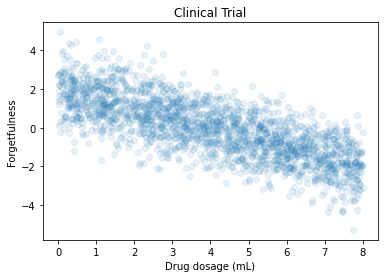

In [7]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x[indices], y[indices], alpha=0.1)

### Define model and "randomly" initialize model parameters

In [8]:
def regression(my_x, my_m, my_b):
    return my_x*my_m + my_b

In [9]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

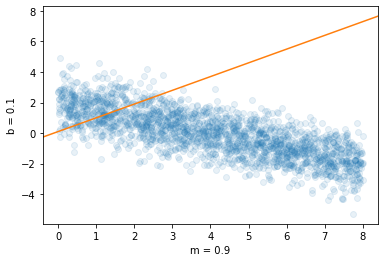

In [10]:
fig, ax = plt.subplots()

ax.scatter(x[indices], y[indices], alpha=0.1)

x_min, x_max = ax.get_xlim()
y_min, y_max = m*x_min + b, m*x_max + b

plt.ylabel('b = {}'.format('%.3g' % b.item()))
plt.xlabel('m = {}'.format('%.3g' % m.item()))

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

### Optimize parameters via SGD

Randomly (*stochastically*) sample a mini-batch of data for gradient descent: 

In [11]:
batch_size = 32 # model hyperparameter

Sample without replacement. If you run out of data (which we won't in this example because we'll do 1000 rounds of training so use 8k data points, 0.1% of the 8m), commence another epoch with the full complement of data (we'll cover this in later NBs).

In [12]:
batch_indices = np.random.choice(n, size=batch_size, replace=False)

In [13]:
x[batch_indices]

tensor([7.2894, 3.4176, 4.5081, 4.0586, 4.2343, 0.7974, 2.4974, 6.3466, 4.6832,
        7.6599, 5.1981, 1.7992, 1.1342, 6.7925, 5.6772, 6.2090, 7.1356, 7.6577,
        4.8597, 7.0404, 7.9052, 1.5491, 6.3357, 5.8022, 1.9294, 3.2062, 5.1424,
        4.9199, 1.9978, 1.1224, 2.1819, 0.2313])

Other than sampling a mini-batch, we optimize by following identical steps to those in the *Gradient Descent from Scratch* notebook: 

**Step 1**: Forward pass

In [14]:
yhat = regression(x[batch_indices], m, b)
yhat

tensor([6.6605, 3.1759, 4.1573, 3.7528, 3.9109, 0.8176, 2.3477, 5.8119, 4.3149,
        6.9939, 4.7783, 1.7193, 1.1208, 6.2132, 5.2095, 5.6881, 6.5220, 6.9919,
        4.4737, 6.4363, 7.2147, 1.4942, 5.8021, 5.3220, 1.8364, 2.9856, 4.7282,
        4.5279, 1.8980, 1.1101, 2.0637, 0.3082], grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

In [15]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [16]:
C = mse(yhat, y[batch_indices])
C

tensor(30.6121, grad_fn=<DivBackward0>)

In [17]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):
    
    title = 'Cost = {}'.format('%.3g' % my_C.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % my_m.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % my_b.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % my_m.item())        
        ylabel = 'b = {}'.format('%.3g' % my_b.item())
    
    fig, ax = plt.subplots()
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = my_m*x_min + my_b, my_m*x_max + my_b

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

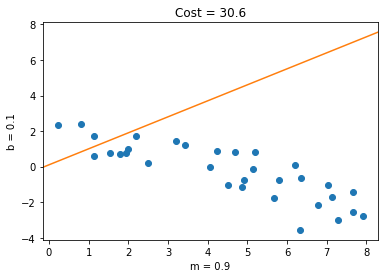

In [18]:
labeled_regression_plot(x[batch_indices], y[batch_indices], m, b, C, include_grad=False)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [19]:
C.backward()

In [20]:
m.grad

tensor([53.4475])

In [21]:
b.grad

tensor([8.5877])

The gradient of cost, $\nabla C$, is: 

In [22]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 8.5877],
        [53.4475]])

The vector of parameters $\boldsymbol{\theta}$ is: 

In [23]:
theta = torch.tensor([[b, m]]).T 
theta

tensor([[0.1000],
        [0.9000]])

**Step 4**: Gradient descent $$ \boldsymbol{\theta}' = \boldsymbol{\theta} - \alpha \nabla C $$

In [24]:
lr = 0.01

In [25]:
new_theta = theta - lr*gradient
new_theta

tensor([[0.0141],
        [0.3655]])

That's it! Let's update the `m` and `b` variables and confirm the correspond to a lower cost $C$: 

In [26]:
b = new_theta[0]
m = new_theta[1]

In [27]:
C = mse(regression(x, m, b), y)
C

tensor(7.1745)

### Rinse and Repeat

In [28]:
b.requires_grad_()
_ = m.requires_grad_() 

Instead of looping through epochs, we'll loop through rounds of SGD: 

In [29]:
rounds = 100 # Use additional rounds (e.g., 1000) for better fit (or use a "fancy" optimizer)
for r in range(rounds): 
    
    # This sampling step is slow; we'll cover much quicker batch sampling later: 
    batch_indices = np.random.choice(n, size=batch_size, replace=False)
    
    yhat = regression(x[batch_indices], m, b) # Step 1
    C = mse(yhat, y[batch_indices]) # Step 2
    
    C.backward() # Step 3
    
    if r % 10 == 0:
        print('Step {}, cost {}, m grad {}, b grad {}'.format(r, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))
    
    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T 
    
    new_theta = theta - lr*gradient # Step 4
    
    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()

Step 0, cost 8.31, m grad 27, b grad 4.04
Step 10, cost 1.85, m grad 3.36, b grad -0.397
Step 20, cost 1.54, m grad -2.39, b grad -1.15
Step 30, cost 2.32, m grad 0.31, b grad -1.26
Step 40, cost 2.11, m grad 0.0417, b grad -0.813
Step 50, cost 1.15, m grad -1.25, b grad -0.779
Step 60, cost 1.24, m grad -0.288, b grad -0.487
Step 70, cost 1.66, m grad 0.536, b grad -0.412
Step 80, cost 1.56, m grad -0.425, b grad -0.644
Step 90, cost 1.52, m grad 1.38, b grad -0.266


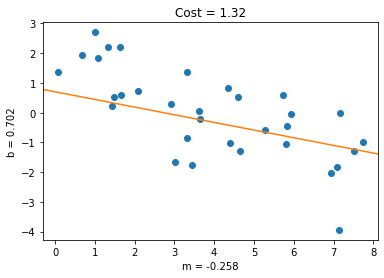

In [30]:
labeled_regression_plot(x[batch_indices], y[batch_indices], m, b, C, include_grad=False)

Since we have so many data points and we were sampling without replacement throughout this notebook, we can use our initial `indices` sample as model *validation data*:

In [31]:
validation_cost = mse(regression(x[indices], m, b), y[indices])

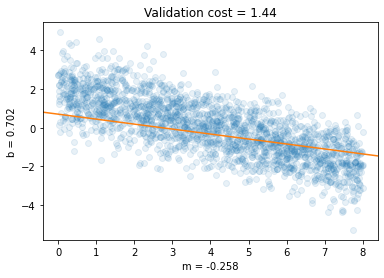

In [32]:
fig, ax = plt.subplots()

ax.scatter(x[indices], y[indices], alpha=0.1)

x_min, x_max = ax.get_xlim()
y_min, y_max = m*x_min + b, m*x_max + b

plt.title('Validation cost = {}'.format('%.3g' % validation_cost.item()))
plt.ylabel('b = {}'.format('%.3g' % b.item()))
plt.xlabel('m = {}'.format('%.3g' % m.item()))

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')